In [54]:
import os
import numpy as np
import matplotlib.pyplot as plt
import itertools

from skimage.io import imread
from skimage.transform import resize
from skimage.filters import threshold_otsu
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.utils import class_weight

from keras import backend as K
from keras.models import Model, load_model
from keras.layers import Input, concatenate, Flatten, Dropout, Conv2D, MaxPooling2D, Conv2DTranspose, Lambda, add, GlobalAveragePooling2D, Dense
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.layers.normalization import BatchNormalization
from keras.layers import BatchNormalization
from keras.preprocessing.image import img_to_array
from keras.layers.advanced_activations import LeakyReLU, PReLU

np.random.seed(103)

In [2]:
melanoma_path = 'melanoma/'
others_path = 'others/'
gt_path = 'gt/'

In [3]:
images_melanoma = os.listdir(melanoma_path)
images_others = os.listdir(others_path)
images = images_melanoma + images_others
images = sorted(images)
img_masks = os.listdir(gt_path)
img_masks = sorted(img_masks)
print(len(images), len(img_masks))

2000 2000


In [4]:
img_rows = 256
img_cols = 256

In [5]:
total = len(images_melanoma) + len(images_others)
imgs = np.ndarray((total, img_rows, img_cols, 3), dtype = np.float)
labels = np.ndarray((total), dtype = np.float)

print (imgs.shape)
print (labels.shape)

(2000, 256, 256, 3)
(2000,)


In [27]:
i = 0
for image_mask_name in img_masks:
    image_mask = imread(gt_path + image_mask_name)
    image_mask = resize(image_mask, (img_rows, img_cols, 1))
    thresh = threshold_otsu(image_mask)
    image_mask = image_mask > thresh
    
    image_name = image_mask_name.split('_')[0:2]
    image_name = '_'.join(image_name)
    image_name += '.jpg'
    
    if image_name in images_melanoma:
        image = imread(melanoma_path + image_name, as_grey=False)  
        image = resize(image, (img_rows, img_cols, 3))
        image = img_to_array(image)
        image = np.multiply(image, image_mask)
        imgs[i] = image
        labels[i] = 1
        print(i, ' ', image_name, ' ', image_mask_name, ' Melanoma')
    else:
        image = imread(others_path + image_name, as_grey=False)  
        image = resize(image, (img_rows, img_cols, 3))
        image = img_to_array(image)
        image = np.multiply(image, image_mask)
        imgs[i] = image
        labels[i] = 0
        print(i, ' ', image_name, ' ', image_mask_name, ' Others')
    i = i + 1
    
print("----")

c:\users\ananda\appdata\local\programs\python\python36\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


0   ISIC_0000000.jpg   ISIC_0000000_segmentation.png  Others
1   ISIC_0000001.jpg   ISIC_0000001_segmentation.png  Others
2   ISIC_0000002.jpg   ISIC_0000002_segmentation.png  Melanoma
3   ISIC_0000003.jpg   ISIC_0000003_segmentation.png  Others
4   ISIC_0000004.jpg   ISIC_0000004_segmentation.png  Melanoma
5   ISIC_0000006.jpg   ISIC_0000006_segmentation.png  Others
6   ISIC_0000007.jpg   ISIC_0000007_segmentation.png  Others
7   ISIC_0000008.jpg   ISIC_0000008_segmentation.png  Others
8   ISIC_0000009.jpg   ISIC_0000009_segmentation.png  Others
9   ISIC_0000010.jpg   ISIC_0000010_segmentation.png  Others
10   ISIC_0000011.jpg   ISIC_0000011_segmentation.png  Others
11   ISIC_0000012.jpg   ISIC_0000012_segmentation.png  Others
12   ISIC_0000013.jpg   ISIC_0000013_segmentation.png  Melanoma
13   ISIC_0000014.jpg   ISIC_0000014_segmentation.png  Others
14   ISIC_0000015.jpg   ISIC_0000015_segmentation.png  Others
15   ISIC_0000016.jpg   ISIC_0000016_segmentation.png  Others
16   ISIC_00

132   ISIC_0000146.jpg   ISIC_0000146_segmentation.png  Melanoma
133   ISIC_0000147.jpg   ISIC_0000147_segmentation.png  Melanoma
134   ISIC_0000148.jpg   ISIC_0000148_segmentation.png  Melanoma
135   ISIC_0000149.jpg   ISIC_0000149_segmentation.png  Melanoma
136   ISIC_0000150.jpg   ISIC_0000150_segmentation.png  Melanoma
137   ISIC_0000151.jpg   ISIC_0000151_segmentation.png  Melanoma
138   ISIC_0000152.jpg   ISIC_0000152_segmentation.png  Melanoma
139   ISIC_0000153.jpg   ISIC_0000153_segmentation.png  Melanoma
140   ISIC_0000154.jpg   ISIC_0000154_segmentation.png  Melanoma
141   ISIC_0000155.jpg   ISIC_0000155_segmentation.png  Melanoma
142   ISIC_0000156.jpg   ISIC_0000156_segmentation.png  Melanoma
143   ISIC_0000157.jpg   ISIC_0000157_segmentation.png  Melanoma
144   ISIC_0000159.jpg   ISIC_0000159_segmentation.png  Melanoma
145   ISIC_0000160.jpg   ISIC_0000160_segmentation.png  Melanoma
146   ISIC_0000161.jpg   ISIC_0000161_segmentation.png  Melanoma
147   ISIC_0000162.jpg   

262   ISIC_0000314.jpg   ISIC_0000314_segmentation.png  Melanoma
263   ISIC_0000315.jpg   ISIC_0000315_segmentation.png  Others
264   ISIC_0000316.jpg   ISIC_0000316_segmentation.png  Others
265   ISIC_0000317.jpg   ISIC_0000317_segmentation.png  Others
266   ISIC_0000319.jpg   ISIC_0000319_segmentation.png  Others
267   ISIC_0000320.jpg   ISIC_0000320_segmentation.png  Others
268   ISIC_0000321.jpg   ISIC_0000321_segmentation.png  Others
269   ISIC_0000322.jpg   ISIC_0000322_segmentation.png  Others
270   ISIC_0000323.jpg   ISIC_0000323_segmentation.png  Others
271   ISIC_0000324.jpg   ISIC_0000324_segmentation.png  Others
272   ISIC_0000325.jpg   ISIC_0000325_segmentation.png  Others
273   ISIC_0000326.jpg   ISIC_0000326_segmentation.png  Others
274   ISIC_0000327.jpg   ISIC_0000327_segmentation.png  Others
275   ISIC_0000328.jpg   ISIC_0000328_segmentation.png  Others
276   ISIC_0000329.jpg   ISIC_0000329_segmentation.png  Others
277   ISIC_0000330.jpg   ISIC_0000330_segmentation.pn

393   ISIC_0000488.jpg   ISIC_0000488_segmentation.png  Others
394   ISIC_0000489.jpg   ISIC_0000489_segmentation.png  Others
395   ISIC_0000490.jpg   ISIC_0000490_segmentation.png  Others
396   ISIC_0000491.jpg   ISIC_0000491_segmentation.png  Others
397   ISIC_0000492.jpg   ISIC_0000492_segmentation.png  Others
398   ISIC_0000493.jpg   ISIC_0000493_segmentation.png  Others
399   ISIC_0000494.jpg   ISIC_0000494_segmentation.png  Others
400   ISIC_0000495.jpg   ISIC_0000495_segmentation.png  Others
401   ISIC_0000496.jpg   ISIC_0000496_segmentation.png  Others
402   ISIC_0000498.jpg   ISIC_0000498_segmentation.png  Others
403   ISIC_0000499.jpg   ISIC_0000499_segmentation.png  Others
404   ISIC_0000500.jpg   ISIC_0000500_segmentation.png  Others
405   ISIC_0000501.jpg   ISIC_0000501_segmentation.png  Others
406   ISIC_0000503.jpg   ISIC_0000503_segmentation.png  Others
407   ISIC_0000504.jpg   ISIC_0000504_segmentation.png  Others
408   ISIC_0000505.jpg   ISIC_0000505_segmentation.png 

522   ISIC_0005555.jpg   ISIC_0005555_segmentation.png  Others
523   ISIC_0005620.jpg   ISIC_0005620_segmentation.png  Others
524   ISIC_0005639.jpg   ISIC_0005639_segmentation.png  Others
525   ISIC_0005666.jpg   ISIC_0005666_segmentation.png  Others
526   ISIC_0005787.jpg   ISIC_0005787_segmentation.png  Others
527   ISIC_0006021.jpg   ISIC_0006021_segmentation.png  Others
528   ISIC_0006114.jpg   ISIC_0006114_segmentation.png  Others
529   ISIC_0006193.jpg   ISIC_0006193_segmentation.png  Others
530   ISIC_0006326.jpg   ISIC_0006326_segmentation.png  Others
531   ISIC_0006350.jpg   ISIC_0006350_segmentation.png  Others
532   ISIC_0006612.jpg   ISIC_0006612_segmentation.png  Others
533   ISIC_0006711.jpg   ISIC_0006711_segmentation.png  Others
534   ISIC_0006776.jpg   ISIC_0006776_segmentation.png  Others
535   ISIC_0006795.jpg   ISIC_0006795_segmentation.png  Others
536   ISIC_0006800.jpg   ISIC_0006800_segmentation.png  Others
537   ISIC_0006940.jpg   ISIC_0006940_segmentation.png 

652   ISIC_0009955.jpg   ISIC_0009955_segmentation.png  Melanoma
653   ISIC_0009956.jpg   ISIC_0009956_segmentation.png  Others
654   ISIC_0009958.jpg   ISIC_0009958_segmentation.png  Others
655   ISIC_0009960.jpg   ISIC_0009960_segmentation.png  Melanoma
656   ISIC_0009961.jpg   ISIC_0009961_segmentation.png  Others
657   ISIC_0009962.jpg   ISIC_0009962_segmentation.png  Others
658   ISIC_0009963.jpg   ISIC_0009963_segmentation.png  Others
659   ISIC_0009964.jpg   ISIC_0009964_segmentation.png  Others
660   ISIC_0009965.jpg   ISIC_0009965_segmentation.png  Others
661   ISIC_0009966.jpg   ISIC_0009966_segmentation.png  Others
662   ISIC_0009967.jpg   ISIC_0009967_segmentation.png  Others
663   ISIC_0009968.jpg   ISIC_0009968_segmentation.png  Others
664   ISIC_0009969.jpg   ISIC_0009969_segmentation.png  Others
665   ISIC_0009971.jpg   ISIC_0009971_segmentation.png  Melanoma
666   ISIC_0009972.jpg   ISIC_0009972_segmentation.png  Others
667   ISIC_0009973.jpg   ISIC_0009973_segmentatio

782   ISIC_0010241.jpg   ISIC_0010241_segmentation.png  Melanoma
783   ISIC_0010244.jpg   ISIC_0010244_segmentation.png  Others
784   ISIC_0010246.jpg   ISIC_0010246_segmentation.png  Others
785   ISIC_0010247.jpg   ISIC_0010247_segmentation.png  Others
786   ISIC_0010248.jpg   ISIC_0010248_segmentation.png  Others
787   ISIC_0010249.jpg   ISIC_0010249_segmentation.png  Others
788   ISIC_0010251.jpg   ISIC_0010251_segmentation.png  Melanoma
789   ISIC_0010254.jpg   ISIC_0010254_segmentation.png  Others
790   ISIC_0010255.jpg   ISIC_0010255_segmentation.png  Others
791   ISIC_0010256.jpg   ISIC_0010256_segmentation.png  Others
792   ISIC_0010257.jpg   ISIC_0010257_segmentation.png  Others
793   ISIC_0010261.jpg   ISIC_0010261_segmentation.png  Others
794   ISIC_0010262.jpg   ISIC_0010262_segmentation.png  Others
795   ISIC_0010264.jpg   ISIC_0010264_segmentation.png  Others
796   ISIC_0010265.jpg   ISIC_0010265_segmentation.png  Melanoma
797   ISIC_0010267.jpg   ISIC_0010267_segmentatio

912   ISIC_0010848.jpg   ISIC_0010848_segmentation.png  Others
913   ISIC_0010850.jpg   ISIC_0010850_segmentation.png  Others
914   ISIC_0010851.jpg   ISIC_0010851_segmentation.png  Others
915   ISIC_0010852.jpg   ISIC_0010852_segmentation.png  Melanoma
916   ISIC_0010853.jpg   ISIC_0010853_segmentation.png  Others
917   ISIC_0010854.jpg   ISIC_0010854_segmentation.png  Others
918   ISIC_0010856.jpg   ISIC_0010856_segmentation.png  Others
919   ISIC_0010857.jpg   ISIC_0010857_segmentation.png  Others
920   ISIC_0010858.jpg   ISIC_0010858_segmentation.png  Others
921   ISIC_0010860.jpg   ISIC_0010860_segmentation.png  Melanoma
922   ISIC_0010861.jpg   ISIC_0010861_segmentation.png  Others
923   ISIC_0010862.jpg   ISIC_0010862_segmentation.png  Melanoma
924   ISIC_0010863.jpg   ISIC_0010863_segmentation.png  Melanoma
925   ISIC_0010864.jpg   ISIC_0010864_segmentation.png  Others
926   ISIC_0011079.jpg   ISIC_0011079_segmentation.png  Others
927   ISIC_0011082.jpg   ISIC_0011082_segmentat

1042   ISIC_0011372.jpg   ISIC_0011372_segmentation.png  Others
1043   ISIC_0011382.jpg   ISIC_0011382_segmentation.png  Others
1044   ISIC_0011384.jpg   ISIC_0011384_segmentation.png  Others
1045   ISIC_0011386.jpg   ISIC_0011386_segmentation.png  Others
1046   ISIC_0011387.jpg   ISIC_0011387_segmentation.png  Melanoma
1047   ISIC_0011393.jpg   ISIC_0011393_segmentation.png  Others
1048   ISIC_0011397.jpg   ISIC_0011397_segmentation.png  Others
1049   ISIC_0011398.jpg   ISIC_0011398_segmentation.png  Others
1050   ISIC_0011402.jpg   ISIC_0011402_segmentation.png  Others
1051   ISIC_0012089.jpg   ISIC_0012089_segmentation.png  Others
1052   ISIC_0012090.jpg   ISIC_0012090_segmentation.png  Others
1053   ISIC_0012094.jpg   ISIC_0012094_segmentation.png  Others
1054   ISIC_0012097.jpg   ISIC_0012097_segmentation.png  Others
1055   ISIC_0012102.jpg   ISIC_0012102_segmentation.png  Others
1056   ISIC_0012103.jpg   ISIC_0012103_segmentation.png  Others
1057   ISIC_0012105.jpg   ISIC_0012105

1170   ISIC_0012475.jpg   ISIC_0012475_segmentation.png  Others
1171   ISIC_0012478.jpg   ISIC_0012478_segmentation.png  Others
1172   ISIC_0012481.jpg   ISIC_0012481_segmentation.png  Others
1173   ISIC_0012487.jpg   ISIC_0012487_segmentation.png  Others
1174   ISIC_0012489.jpg   ISIC_0012489_segmentation.png  Others
1175   ISIC_0012494.jpg   ISIC_0012494_segmentation.png  Others
1176   ISIC_0012495.jpg   ISIC_0012495_segmentation.png  Others
1177   ISIC_0012496.jpg   ISIC_0012496_segmentation.png  Others
1178   ISIC_0012501.jpg   ISIC_0012501_segmentation.png  Others
1179   ISIC_0012503.jpg   ISIC_0012503_segmentation.png  Others
1180   ISIC_0012506.jpg   ISIC_0012506_segmentation.png  Others
1181   ISIC_0012508.jpg   ISIC_0012508_segmentation.png  Others
1182   ISIC_0012511.jpg   ISIC_0012511_segmentation.png  Others
1183   ISIC_0012512.jpg   ISIC_0012512_segmentation.png  Melanoma
1184   ISIC_0012516.jpg   ISIC_0012516_segmentation.png  Others
1185   ISIC_0012517.jpg   ISIC_0012517

1298   ISIC_0012891.jpg   ISIC_0012891_segmentation.png  Others
1299   ISIC_0012897.jpg   ISIC_0012897_segmentation.png  Others
1300   ISIC_0012898.jpg   ISIC_0012898_segmentation.png  Others
1301   ISIC_0012901.jpg   ISIC_0012901_segmentation.png  Others
1302   ISIC_0012902.jpg   ISIC_0012902_segmentation.png  Others
1303   ISIC_0012905.jpg   ISIC_0012905_segmentation.png  Others
1304   ISIC_0012907.jpg   ISIC_0012907_segmentation.png  Others
1305   ISIC_0012911.jpg   ISIC_0012911_segmentation.png  Others
1306   ISIC_0012930.jpg   ISIC_0012930_segmentation.png  Melanoma
1307   ISIC_0012932.jpg   ISIC_0012932_segmentation.png  Others
1308   ISIC_0012939.jpg   ISIC_0012939_segmentation.png  Others
1309   ISIC_0012940.jpg   ISIC_0012940_segmentation.png  Others
1310   ISIC_0012944.jpg   ISIC_0012944_segmentation.png  Others
1311   ISIC_0012945.jpg   ISIC_0012945_segmentation.png  Others
1312   ISIC_0012949.jpg   ISIC_0012949_segmentation.png  Others
1313   ISIC_0012950.jpg   ISIC_0012950

1426   ISIC_0013233.jpg   ISIC_0013233_segmentation.png  Others
1427   ISIC_0013235.jpg   ISIC_0013235_segmentation.png  Others
1428   ISIC_0013236.jpg   ISIC_0013236_segmentation.png  Others
1429   ISIC_0013238.jpg   ISIC_0013238_segmentation.png  Others
1430   ISIC_0013243.jpg   ISIC_0013243_segmentation.png  Others
1431   ISIC_0013244.jpg   ISIC_0013244_segmentation.png  Others
1432   ISIC_0013248.jpg   ISIC_0013248_segmentation.png  Others
1433   ISIC_0013249.jpg   ISIC_0013249_segmentation.png  Others
1434   ISIC_0013257.jpg   ISIC_0013257_segmentation.png  Others
1435   ISIC_0013258.jpg   ISIC_0013258_segmentation.png  Melanoma
1436   ISIC_0013268.jpg   ISIC_0013268_segmentation.png  Others
1437   ISIC_0013274.jpg   ISIC_0013274_segmentation.png  Others
1438   ISIC_0013275.jpg   ISIC_0013275_segmentation.png  Others
1439   ISIC_0013287.jpg   ISIC_0013287_segmentation.png  Others
1440   ISIC_0013288.jpg   ISIC_0013288_segmentation.png  Others
1441   ISIC_0013294.jpg   ISIC_0013294

1554   ISIC_0013652.jpg   ISIC_0013652_segmentation.png  Melanoma
1555   ISIC_0013656.jpg   ISIC_0013656_segmentation.png  Others
1556   ISIC_0013664.jpg   ISIC_0013664_segmentation.png  Others
1557   ISIC_0013667.jpg   ISIC_0013667_segmentation.png  Others
1558   ISIC_0013670.jpg   ISIC_0013670_segmentation.png  Others
1559   ISIC_0013671.jpg   ISIC_0013671_segmentation.png  Melanoma
1560   ISIC_0013672.jpg   ISIC_0013672_segmentation.png  Melanoma
1561   ISIC_0013674.jpg   ISIC_0013674_segmentation.png  Melanoma
1562   ISIC_0013675.jpg   ISIC_0013675_segmentation.png  Others
1563   ISIC_0013676.jpg   ISIC_0013676_segmentation.png  Others
1564   ISIC_0013680.jpg   ISIC_0013680_segmentation.png  Others
1565   ISIC_0013682.jpg   ISIC_0013682_segmentation.png  Others
1566   ISIC_0013684.jpg   ISIC_0013684_segmentation.png  Others
1567   ISIC_0013685.jpg   ISIC_0013685_segmentation.png  Others
1568   ISIC_0013687.jpg   ISIC_0013687_segmentation.png  Others
1569   ISIC_0013688.jpg   ISIC_0

1682   ISIC_0014049.jpg   ISIC_0014049_segmentation.png  Melanoma
1683   ISIC_0014061.jpg   ISIC_0014061_segmentation.png  Melanoma
1684   ISIC_0014062.jpg   ISIC_0014062_segmentation.png  Melanoma
1685   ISIC_0014066.jpg   ISIC_0014066_segmentation.png  Others
1686   ISIC_0014069.jpg   ISIC_0014069_segmentation.png  Others
1687   ISIC_0014072.jpg   ISIC_0014072_segmentation.png  Melanoma
1688   ISIC_0014073.jpg   ISIC_0014073_segmentation.png  Others
1689   ISIC_0014074.jpg   ISIC_0014074_segmentation.png  Others
1690   ISIC_0014076.jpg   ISIC_0014076_segmentation.png  Melanoma
1691   ISIC_0014079.jpg   ISIC_0014079_segmentation.png  Melanoma
1692   ISIC_0014080.jpg   ISIC_0014080_segmentation.png  Others
1693   ISIC_0014081.jpg   ISIC_0014081_segmentation.png  Others
1694   ISIC_0014082.jpg   ISIC_0014082_segmentation.png  Melanoma
1695   ISIC_0014083.jpg   ISIC_0014083_segmentation.png  Others
1696   ISIC_0014088.jpg   ISIC_0014088_segmentation.png  Melanoma
1697   ISIC_0014089.jpg 

1809   ISIC_0014537.jpg   ISIC_0014537_segmentation.png  Others
1810   ISIC_0014543.jpg   ISIC_0014543_segmentation.png  Melanoma
1811   ISIC_0014545.jpg   ISIC_0014545_segmentation.png  Melanoma
1812   ISIC_0014547.jpg   ISIC_0014547_segmentation.png  Others
1813   ISIC_0014554.jpg   ISIC_0014554_segmentation.png  Others
1814   ISIC_0014557.jpg   ISIC_0014557_segmentation.png  Melanoma
1815   ISIC_0014569.jpg   ISIC_0014569_segmentation.png  Others
1816   ISIC_0014570.jpg   ISIC_0014570_segmentation.png  Others
1817   ISIC_0014571.jpg   ISIC_0014571_segmentation.png  Others
1818   ISIC_0014573.jpg   ISIC_0014573_segmentation.png  Others
1819   ISIC_0014576.jpg   ISIC_0014576_segmentation.png  Others
1820   ISIC_0014577.jpg   ISIC_0014577_segmentation.png  Others
1821   ISIC_0014578.jpg   ISIC_0014578_segmentation.png  Others
1822   ISIC_0014579.jpg   ISIC_0014579_segmentation.png  Others
1823   ISIC_0014580.jpg   ISIC_0014580_segmentation.png  Others
1824   ISIC_0014581.jpg   ISIC_001

1937   ISIC_0014845.jpg   ISIC_0014845_segmentation.png  Others
1938   ISIC_0014846.jpg   ISIC_0014846_segmentation.png  Others
1939   ISIC_0014848.jpg   ISIC_0014848_segmentation.png  Others
1940   ISIC_0014849.jpg   ISIC_0014849_segmentation.png  Others
1941   ISIC_0014850.jpg   ISIC_0014850_segmentation.png  Others
1942   ISIC_0014851.jpg   ISIC_0014851_segmentation.png  Others
1943   ISIC_0014855.jpg   ISIC_0014855_segmentation.png  Others
1944   ISIC_0014860.jpg   ISIC_0014860_segmentation.png  Others
1945   ISIC_0014866.jpg   ISIC_0014866_segmentation.png  Others
1946   ISIC_0014869.jpg   ISIC_0014869_segmentation.png  Others
1947   ISIC_0014890.jpg   ISIC_0014890_segmentation.png  Others
1948   ISIC_0014891.jpg   ISIC_0014891_segmentation.png  Melanoma
1949   ISIC_0014897.jpg   ISIC_0014897_segmentation.png  Melanoma
1950   ISIC_0014898.jpg   ISIC_0014898_segmentation.png  Others
1951   ISIC_0014903.jpg   ISIC_0014903_segmentation.png  Others
1952   ISIC_0014904.jpg   ISIC_00149

In [28]:
np.save('imgs_classify.npy', imgs)
np.save('labels.npy', labels)

In [ ]:
X = imgs
Y = labels

In [5]:
X = np.load('imgs_classify.npy')
Y = np.load('labels.npy')

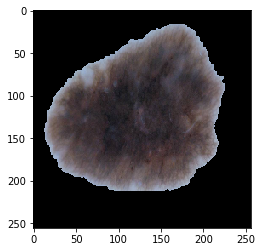

In [6]:
plt.imshow(X[0])

In [7]:
print (X.shape)
print (Y.shape)

(2000, 256, 256, 3)
(2000,)


In [7]:
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.20, random_state=78)

In [8]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(trainY), trainY)
print (class_weights)

[0.61538462 2.66666667]


In [9]:
def precision(y_true, y_pred):
    '''Calculates the precision, a metric for multi-label classification of
    how many selected items are relevant.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    '''Calculates the recall, a metric for multi-label classification of
    how many relevant items are selected.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fbeta_score(y_true, y_pred, beta=1):
    '''Calculates the F score, the weighted harmonic mean of precision and recall.
    This is useful for multi-label classification, where input samples can be
    classified as sets of labels. By only using accuracy (precision) a model
    would achieve a perfect score by simply assigning every class to every
    input. In order to avoid this, a metric should penalize incorrect class
    assignments as well (recall). The F-beta score (ranged from 0.0 to 1.0)
    computes this, as a weighted mean of the proportion of correct class
    assignments vs. the proportion of incorrect class assignments.
    With beta = 1, this is equivalent to a F-measure. With beta < 1, assigning
    correct classes becomes more important, and with beta > 1 the metric is
    instead weighted towards penalizing incorrect class assignments.
    '''
    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')
        
    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score


def fmeasure(y_true, y_pred):
    '''Calculates the f-measure, the harmonic mean of precision and recall.
    '''
    return fbeta_score(y_true, y_pred, beta=1)

In [22]:
def get_cnn():
    def add_common_layers(y):
        y = BatchNormalization()(y)
        y = LeakyReLU()(y)
        return y
    inputs = Input((img_rows, img_cols, 3))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    #conv1 = add_common_layers(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(64, (2, 2), activation='relu', padding='same')(pool1)
    #conv2 = add_common_layers(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    flatten = Flatten()(pool2)
    dense1 = Dense(256, activation = 'relu')(flatten)
    drop = Dropout(0.5)(dense1)
    dense2 = Dense(1, activation = 'sigmoid')(drop)
    
    model = Model(inputs=[inputs], outputs=[dense2])
    
    model.compile(optimizer=Adam(lr=0.0002), loss='binary_crossentropy', metrics=['accuracy', fmeasure, precision, recall])
    
    return model

In [23]:
cnn = get_cnn()
print(cnn.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      8256      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 262144)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               67109120  
__________

In [24]:
classifier = cnn.fit(trainX,trainY, batch_size = 8, epochs = 20, verbose = True, validation_data = (testX, testY), class_weight=[1, 8])

Train on 1600 samples, validate on 400 samples
Epoch 1/20
1600/1600 [==============================] - 51s 32ms/step - loss: 0.5728 - acc: 0.7969 - fmeasure: 0.0617 - precision: 0.0729 - recall: 0.0652 - val_loss: 0.4644 - val_acc: 0.8150 - val_fmeasure: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
1600/1600 [==============================] - 50s 31ms/step - loss: 0.4243 - acc: 0.8187 - fmeasure: 0.0835 - precision: 0.1075 - recall: 0.0750 - val_loss: 0.4925 - val_acc: 0.8025 - val_fmeasure: 0.1193 - val_precision: 0.1567 - val_recall: 0.1167
Epoch 3/20
1600/1600 [==============================] - 51s 32ms/step - loss: 0.3442 - acc: 0.8494 - fmeasure: 0.2469 - precision: 0.3367 - recall: 0.2121 - val_loss: 0.5284 - val_acc: 0.8150 - val_fmeasure: 0.0733 - val_precision: 0.0900 - val_recall: 0.0667
Epoch 4/20
1600/1600 [==============================] - 50s 31ms/step - loss: 0.2428 - acc: 0.9075 - fmeasure: 0.4922 - precision: 0.5808 - recall: 0.4520 - val_

In [35]:
prediction = cnn.predict(testX)

Normalized confusion matrix
[[0.89570552 0.10429448]
 [0.83783784 0.16216216]]


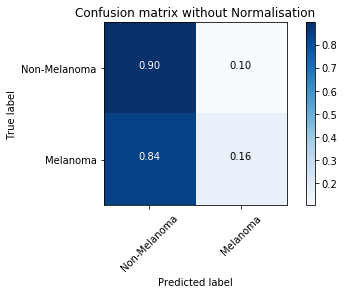

Precision :  0.2608695652173913
Recall :  0.16216216216216217
f1 score :  0.2


In [69]:
predictions = prediction >= 0.5
conf_matrix = confusion_matrix(testY,predictions)
class_names = ['Non-Melanoma', 'Melanoma']
plot_confusion_matrix(conf_matrix, classes=class_names,normalize= True,
                      name = "NB_Confusion_matrix_without_normalisation.png",
                      title='Confusion matrix without Normalisation')
print('Precision : ', precision_score(testY, predictions))
print('Recall : ', recall_score(testY, predictions))
print('f1 score : ',f1_score(testY, predictions))

In [20]:
K.clear_session()

In [48]:
def get_cnn2():
    def add_common_layers(y):
        y = BatchNormalization()(y)
        y = LeakyReLU()(y)
        return y
    inputs = Input((img_rows, img_cols, 3))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    #conv1 = add_common_layers(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    #conv2 = add_common_layers(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    #conv2 = add_common_layers(conv2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    flatten = Flatten()(pool3)
    dense1 = Dense(256, activation = 'relu')(flatten)
    drop = Dropout(0.25)(dense1)
    dense2 = Dense(1, activation = 'sigmoid')(drop)
    
    model = Model(inputs=[inputs], outputs=[dense2])
    
    model.compile(optimizer=Adam(lr=0.0002), loss='binary_crossentropy', metrics=['accuracy', fmeasure, precision, recall])
    
    return model

In [49]:
cnn2 = get_cnn2()
print(cnn2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 32, 32, 128)       0         
__________

In [50]:
classifier = cnn2.fit(trainX,trainY, batch_size = 8, epochs = 20, verbose = True, validation_data = (testX, testY), class_weight=[1, 8])

Train on 1600 samples, validate on 400 samples
Epoch 1/20
1600/1600 [==============================] - 38s 24ms/step - loss: 0.4833 - acc: 0.8038 - fmeasure: 0.0082 - precision: 0.0099 - recall: 0.0117 - val_loss: 0.5221 - val_acc: 0.8150 - val_fmeasure: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
1600/1600 [==============================] - 36s 22ms/step - loss: 0.4426 - acc: 0.8119 - fmeasure: 0.0050 - precision: 0.0050 - recall: 0.0050 - val_loss: 0.4657 - val_acc: 0.8150 - val_fmeasure: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
1600/1600 [==============================] - 36s 23ms/step - loss: 0.4009 - acc: 0.8337 - fmeasure: 0.1490 - precision: 0.2100 - recall: 0.1247 - val_loss: 0.4950 - val_acc: 0.8150 - val_fmeasure: 0.0613 - val_precision: 0.0800 - val_recall: 0.0550
Epoch 4/20
1600/1600 [==============================] - 36s 23ms/step - loss: 0.3271 - acc: 0.8600 - fmeasure: 0.3335 - precision: 0.4117 - recall: 0

In [51]:
prediction2 = cnn2.predict(testX)

Normalized confusion matrix
[[0.86503067 0.13496933]
 [0.78378378 0.21621622]]


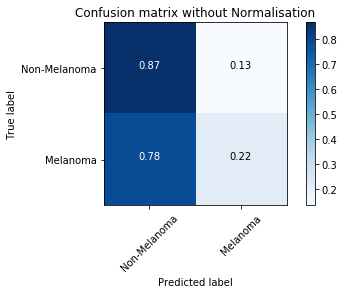

Precision :  0.26666666666666666
Recall :  0.21621621621621623
f1 score :  0.23880597014925373


In [58]:
predictions2 = prediction2 >= 0.5
conf_matrix = confusion_matrix(testY,predictions2)
class_names = ['Non-Melanoma', 'Melanoma']
plot_confusion_matrix(conf_matrix, classes=class_names,normalize= True,
                      name = "NB_Confusion_matrix_without_normalisation.png",
                      title='Confusion matrix without Normalisation')
print('Precision : ', precision_score(testY, predictions2))
print('Recall : ', recall_score(testY, predictions2))
print('f1 score : ',f1_score(testY, predictions2))

In [78]:
K.clear_session()

In [79]:
cardinality = 32
def get_residual_network():
    """
    ResNeXt by default. For ResNet set `cardinality` = 1 above.
    
    """
    def add_common_layers(y):
        y = BatchNormalization()(y)
        y = LeakyReLU()(y)
        return y

    def grouped_convolution(y, nb_channels, _strides):
        # when `cardinality` == 1 this is just a standard convolution
        if cardinality == 1:
            return Conv2D(nb_channels, kernel_size=(3, 3), strides=_strides, padding='same')(y)
        
        assert not nb_channels % cardinality
        _d = nb_channels // cardinality

        # in a grouped convolution layer, input and output channels are divided into `cardinality` groups,
        # and convolutions are separately performed within each group
        groups = []
        for j in range(cardinality):
            group = Lambda(lambda z: z[:, :, :, j * _d:j * _d + _d])(y)
            groups.append(Conv2D(_d, kernel_size=(3, 3), strides=_strides, padding='same')(group))
            
        # the grouped convolutional layer concatenates them as the outputs of the layer
        y = concatenate(groups)

        return y

    def residual_block(y, nb_channels_in, nb_channels_out, _strides=(1, 1), _project_shortcut=False):
        """
        Our network consists of a stack of residual blocks. These blocks have the same topology,
        and are subject to two simple rules:
        - If producing spatial maps of the same size, the blocks share the same hyper-parameters (width and filter sizes).
        - Each time the spatial map is down-sampled by a factor of 2, the width of the blocks is multiplied by a factor of 2.
        """
        shortcut = y

        # we modify the residual building block as a bottleneck design to make the network more economical
        y = Conv2D(nb_channels_in, kernel_size=(1, 1), strides=(1, 1), padding='same')(y)
        y = add_common_layers(y)

        # ResNeXt (identical to ResNet when `cardinality` == 1)
        y = grouped_convolution(y, nb_channels_in, _strides=_strides)
        y = add_common_layers(y)

        y = Conv2D(nb_channels_out, kernel_size=(1, 1), strides=(1, 1), padding='same')(y)
        # batch normalization is employed after aggregating the transformations and before adding to the shortcut
        y = BatchNormalization()(y)

        # identity shortcuts used directly when the input and output are of the same dimensions
        if _project_shortcut or _strides != (1, 1):
            # when the dimensions increase projection shortcut is used to match dimensions (done by 1×1 convolutions)
            # when the shortcuts go across feature maps of two sizes, they are performed with a stride of 2
            shortcut = Conv2D(nb_channels_out, kernel_size=(1, 1), strides=_strides, padding='same')(shortcut)
            shortcut = BatchNormalization()(shortcut)

        y = add([shortcut, y])

        # relu is performed right after each batch normalization,
        # expect for the output of the block where relu is performed after the adding to the shortcut
        y = LeakyReLU()(y)

        return y

    # conv1
    inputs = Input((img_rows, img_cols, 3))
    x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='same')(inputs)
    x = add_common_layers(x)

    # conv2
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    for i in range(3):
        project_shortcut = True if i == 0 else False
        x = residual_block(x, 128, 256, _project_shortcut=project_shortcut)

    # conv3
    for i in range(4):
        # down-sampling is performed by conv3_1, conv4_1, and conv5_1 with a stride of 2
        strides = (2, 2) if i == 0 else (1, 1)
        x = residual_block(x, 256, 512, _strides=strides)

    # conv4
    for i in range(6):
        strides = (2, 2) if i == 0 else (1, 1)
        x = residual_block(x, 512, 1024, _strides=strides)

    # conv5
    for i in range(3):
        strides = (2, 2) if i == 0 else (1, 1)
        x = residual_block(x, 1024, 2048, _strides=strides)

    x = GlobalAveragePooling2D()(x)
    x = Dense(1, activation='sigmoid', name='predictions')(x)
    
    model = Model(inputs=[inputs], outputs=[x])
    
    model.compile(optimizer=Adam(lr=0.0004), loss='binary_crossentropy', metrics=['accuracy', fmeasure, precision, recall])

    return model

In [80]:
resnext = get_residual_network()
print(resnext.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 128, 128, 64) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

lambda_290 (Lambda)             (None, 16, 16, 16)   0           leaky_re_lu_29[0][0]             
__________________________________________________________________________________________________
lambda_291 (Lambda)             (None, 16, 16, 16)   0           leaky_re_lu_29[0][0]             
__________________________________________________________________________________________________
lambda_292 (Lambda)             (None, 16, 16, 16)   0           leaky_re_lu_29[0][0]             
__________________________________________________________________________________________________
lambda_293 (Lambda)             (None, 16, 16, 16)   0           leaky_re_lu_29[0][0]             
__________________________________________________________________________________________________
lambda_294 (Lambda)             (None, 16, 16, 16)   0           leaky_re_lu_29[0][0]             
__________________________________________________________________________________________________
lambda_295

Total params: 23,084,289
Trainable params: 23,016,065
Non-trainable params: 68,224
__________________________________________________________________________________________________
None


In [90]:
classifier = resnext.fit(trainX,trainY, batch_size = 10, epochs = 15, verbose = True, validation_data = (testX, testY), class_weight=[1, 4])

Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 299s 187ms/step - loss: 0.4731 - acc: 0.8075 - fmeasure: 0.1542 - precision: 0.2031 - recall: 0.1450 - val_loss: 0.7167 - val_acc: 0.8125 - val_fmeasure: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/15
1600/1600 [==============================] - 339s 212ms/step - loss: 0.4619 - acc: 0.8125 - fmeasure: 0.1524 - precision: 0.2047 - recall: 0.1448 - val_loss: 0.8538 - val_acc: 0.4775 - val_fmeasure: 0.3276 - val_precision: 0.2311 - val_recall: 0.6962
Epoch 3/15
1600/1600 [==============================] - 337s 210ms/step - loss: 0.4611 - acc: 0.8219 - fmeasure: 0.1588 - precision: 0.2172 - recall: 0.1489 - val_loss: 0.5782 - val_acc: 0.8150 - val_fmeasure: 0.0558 - val_precision: 0.0875 - val_recall: 0.0521
Epoch 4/15
1600/1600 [==============================] - 339s 212ms/step - loss: 0.4449 - acc: 0.8100 - fmeasure: 0.1546 - precision: 0.2260 - recall: 0.133

In [26]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,name = "Cf.png",
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    fig = plt.gcf()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    fig.savefig(name)
    plt.show()

In [91]:
prediction3 = resnext.predict(testX)

Normalized confusion matrix
[[0.94478528 0.05521472]
 [0.87837838 0.12162162]]


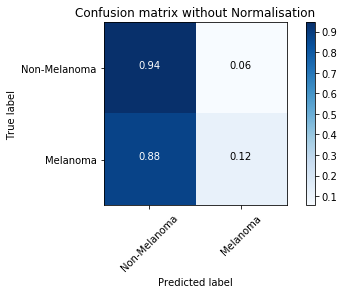

Precision :  0.3333333333333333
Recall :  0.12162162162162163
f1 score :  0.1782178217821782


In [104]:
predictions3 = prediction3 >= 0.5
conf_matrix = confusion_matrix(testY,predictions3)
class_names = ['Non-Melanoma', 'Melanoma']
plot_confusion_matrix(conf_matrix, classes=class_names,normalize= True,
                      name = "NB_Confusion_matrix_without_normalisation.png",
                      title='Confusion matrix without Normalisation')

print('Precision : ', precision_score(testY, predictions3))
print('Recall : ', recall_score(testY, predictions3))
print('f1 score : ',f1_score(testY, predictions3))